# CNN-Based Waste Classification  
## Automated Trash Management  


## 1 · Introduction & Problem Statement  
Computer-vision-based sorting can dramatically improve recycling efficiency, reducing both environmental impact and operational costs.  
We explore two CNN approaches on the Kaggle Waste Classification dataset:  
- **Transfer learning** with a pretrained **ResNet-18**  
- **Training from scratch** with a custom lightweight **CNN**

## 2 · Objectives  
| Goal | Description | Target |  
|------|-------------|--------|  
| Compare ResNet-18 TL vs. scratch CNN | Evaluate accuracy, convergence speed, and model size | Report metrics |  
| ≥ 90 % accuracy | Strive for state-of-the-art performance | Test-set |  
| Reusable pipeline | Modular code, clear documentation | Notebook |  

## 3 · Methodology  
1. Data loading & augmentation  
2. Model A: Freeze pretrained ResNet-18 backbone, fine-tune classifier  
3. Model B: Design 5-block CNN (~6 M parameters) and train from scratch  
4. Evaluate on a held-out test set  
5. Compare metrics with visualisations  

In [7]:
# ==== Imports & Config ========================================================
import os, random, time, copy, json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, accuracy_score

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device(
    'cuda' if torch.cuda.is_available()
    else ('mps' if torch.backends.mps.is_available() else 'cpu')
)
print('Device:', device)

Device: cuda


In [8]:
# ==== Dataset Paths ===========================================================
DATA_DIR  = 'data'          # <- point to your dataset root
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR  = os.path.join(DATA_DIR, 'test')

def count_images(path):
    return {os.path.basename(p): len(glob(os.path.join(p, '*')))
            for p in glob(os.path.join(path, '*'))}

print('Train distribution:', json.dumps(count_images(TRAIN_DIR), indent=2))
print('Test  distribution:', json.dumps(count_images(TEST_DIR),  indent=2))

Train distribution: {}
Test  distribution: {}


In [14]:
# ==== Transforms & DataLoaders ================================================
IMG_SIZE   = 224
BATCH_SIZE = 32
VAL_SPLIT  = 0.20

train_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])       # ImageNet stats
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tf)
val_len  = int(len(train_ds) * VAL_SPLIT)
train_len = len(train_ds) - val_len
train_ds, val_ds = random_split(train_ds, [train_len, val_len])

test_ds = datasets.ImageFolder(TEST_DIR, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4)

class_names = ['Organic', 'Recyclable']
num_classes = len(class_names)

In [15]:
# ==== Helper Functions ========================================================
def train_epoch(model, loader, opt, crit):
    model.train()
    loss_sum = 0
    correct  = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out  = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    n = len(loader.dataset)
    return loss_sum / n, correct / n

@torch.no_grad()
def eval_epoch(model, loader, crit):
    model.eval()
    loss_sum = 0
    correct  = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out  = model(x)
        loss = crit(out, y)
        loss_sum += loss.item() * x.size(0)
        correct  += (out.argmax(1) == y).sum().item()
    n = len(loader.dataset)
    return loss_sum / n, correct / n

## 4 · Model A — ResNet-18 (Transfer Learning)

In [16]:
# Instantiate & freeze backbone
tl_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for p in tl_model.parameters():
    p.requires_grad = False
tl_model.fc = nn.Linear(tl_model.fc.in_features, num_classes)
tl_model    = tl_model.to(device)

tl_crit  = nn.CrossEntropyLoss()
tl_opt   = optim.Adam(tl_model.fc.parameters(), lr=1e-3)
tl_sched = optim.lr_scheduler.StepLR(tl_opt, step_size=5, gamma=0.1)

TL_EPOCHS = 10
tl_hist   = {'tr_loss': [], 'tr_acc': [], 'val_loss': [], 'val_acc': []}
best_acc  = 0
best_wts  = copy.deepcopy(tl_model.state_dict())

for epoch in range(1, TL_EPOCHS+1):
    tr_l, tr_a = train_epoch(tl_model, train_loader, tl_opt, tl_crit)
    v_l, v_a   = eval_epoch(tl_model, val_loader, tl_crit)
    tl_sched.step()
    tl_hist['tr_loss'].append(tr_l); tl_hist['tr_acc'].append(tr_a)
    tl_hist['val_loss'].append(v_l); tl_hist['val_acc'].append(v_a)
    if v_a > best_acc:
        best_acc = v_a
        best_wts = copy.deepcopy(tl_model.state_dict())
    print(f'E{epoch:02}: train {tr_a:.3f}/{tr_l:.3f} · val {v_a:.3f}/{v_l:.3f}')

tl_model.load_state_dict(best_wts)
torch.save(tl_model.state_dict(), 'waste_classifier_resnet18.pt')
print('Best TL val-accuracy:', f'{best_acc:.4f}')

E01: train 0.875/0.303 · val 0.895/0.264
E02: train 0.892/0.265 · val 0.904/0.246
E03: train 0.899/0.251 · val 0.896/0.257
E04: train 0.900/0.250 · val 0.897/0.251
E05: train 0.900/0.250 · val 0.912/0.228
E06: train 0.907/0.235 · val 0.904/0.230
E07: train 0.904/0.238 · val 0.915/0.224
E08: train 0.908/0.235 · val 0.910/0.230
E09: train 0.907/0.234 · val 0.910/0.236
E10: train 0.909/0.232 · val 0.907/0.231
Best TL val-accuracy: 0.9153


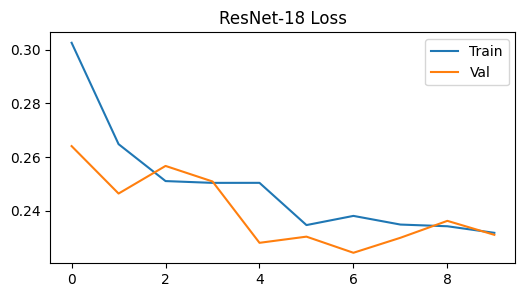

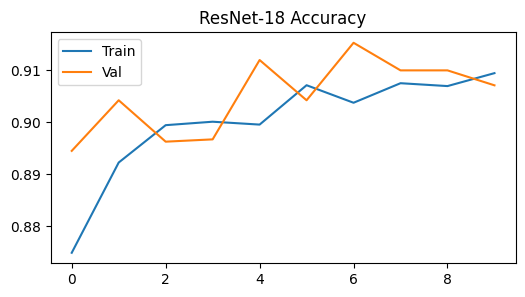

In [17]:
# Plot ResNet-18 curves
plt.figure(figsize=(6,3))
plt.plot(tl_hist['tr_loss'], label='Train')
plt.plot(tl_hist['val_loss'], label='Val')
plt.title('ResNet-18 Loss'); plt.legend(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(tl_hist['tr_acc'], label='Train')
plt.plot(tl_hist['val_acc'], label='Val')
plt.title('ResNet-18 Accuracy'); plt.legend(); plt.show()

## 5 · Model B — Scratch CNN

In [18]:
class ScratchCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128,256,3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256*7*7, 512), nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

sc_model = ScratchCNN(num_classes).to(device)
sc_crit  = nn.CrossEntropyLoss()
sc_opt   = optim.AdamW(sc_model.parameters(), lr=3e-4, weight_decay=1e-4)
sc_sched = optim.lr_scheduler.CosineAnnealingLR(sc_opt, T_max=20)

SCRATCH_EPOCHS = 20
sc_hist  = {'tr_loss': [], 'tr_acc': [], 'val_loss': [], 'val_acc': []}
best_sc  = 0
best_wts = copy.deepcopy(sc_model.state_dict())

for epoch in range(1, SCRATCH_EPOCHS+1):
    tr_l, tr_a = train_epoch(sc_model, train_loader, sc_opt, sc_crit)
    v_l, v_a   = eval_epoch(sc_model, val_loader, sc_crit)
    sc_sched.step()
    sc_hist['tr_loss'].append(tr_l); sc_hist['tr_acc'].append(tr_a)
    sc_hist['val_loss'].append(v_l); sc_hist['val_acc'].append(v_a)
    if v_a > best_sc:
        best_sc = v_a
        best_wts = copy.deepcopy(sc_model.state_dict())
    print(f'E{epoch:02}: train {tr_a:.3f}/{tr_l:.3f} · val {v_a:.3f}/{v_l:.3f}')

sc_model.load_state_dict(best_wts)
torch.save(sc_model.state_dict(), 'waste_classifier_scratch.pt')
print('Best Scratch val-accuracy:', f'{best_sc:.4f}')

E01: train 0.799/0.458 · val 0.815/0.426
E02: train 0.830/0.402 · val 0.818/0.425
E03: train 0.842/0.384 · val 0.843/0.380
E04: train 0.846/0.371 · val 0.848/0.369
E05: train 0.855/0.354 · val 0.854/0.353
E06: train 0.854/0.352 · val 0.851/0.344
E07: train 0.864/0.334 · val 0.856/0.348
E08: train 0.868/0.328 · val 0.861/0.346
E09: train 0.867/0.331 · val 0.869/0.333
E10: train 0.872/0.319 · val 0.863/0.341
E11: train 0.871/0.317 · val 0.871/0.316
E12: train 0.875/0.309 · val 0.874/0.308
E13: train 0.882/0.301 · val 0.871/0.325
E14: train 0.879/0.296 · val 0.876/0.310
E15: train 0.886/0.287 · val 0.883/0.301
E16: train 0.888/0.283 · val 0.884/0.293
E17: train 0.889/0.280 · val 0.885/0.294
E18: train 0.887/0.280 · val 0.877/0.299
E19: train 0.891/0.274 · val 0.878/0.307
E20: train 0.892/0.275 · val 0.885/0.294
Best Scratch val-accuracy: 0.8854


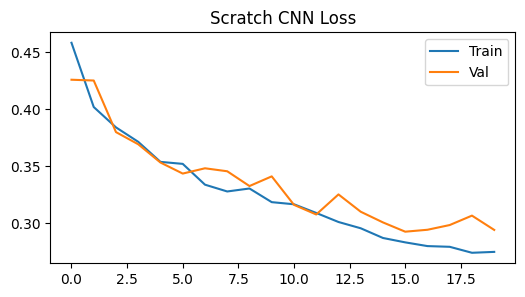

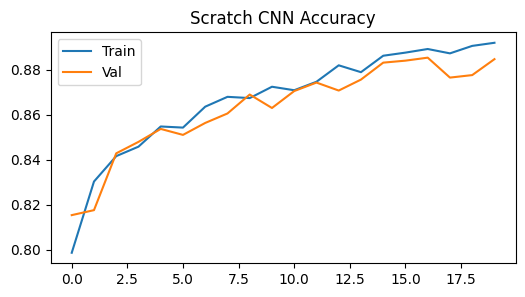

In [19]:
# Plot Scratch curves
plt.figure(figsize=(6,3))
plt.plot(sc_hist['tr_loss'], label='Train')
plt.plot(sc_hist['val_loss'], label='Val')
plt.title('Scratch CNN Loss'); plt.legend(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(sc_hist['tr_acc'], label='Train')
plt.plot(sc_hist['val_acc'], label='Val')
plt.title('Scratch CNN Accuracy'); plt.legend(); plt.show()

## 6 · Test-Set Evaluation & Comparison

ResNet-18 Test Acc: 0.9243931555909272
Scratch CNN Test Acc: 0.9124552327894946


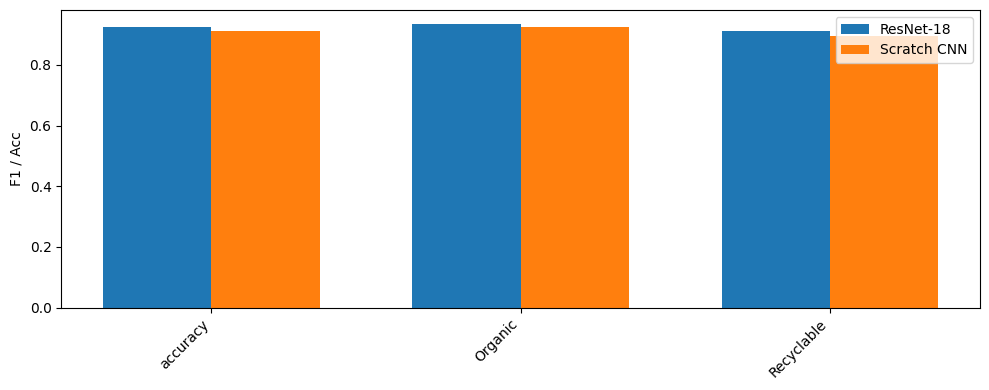

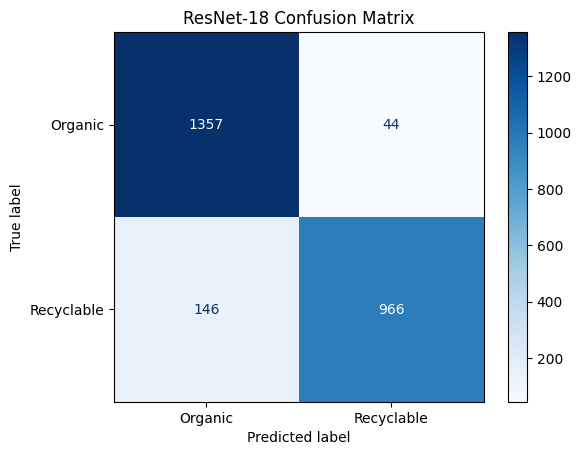

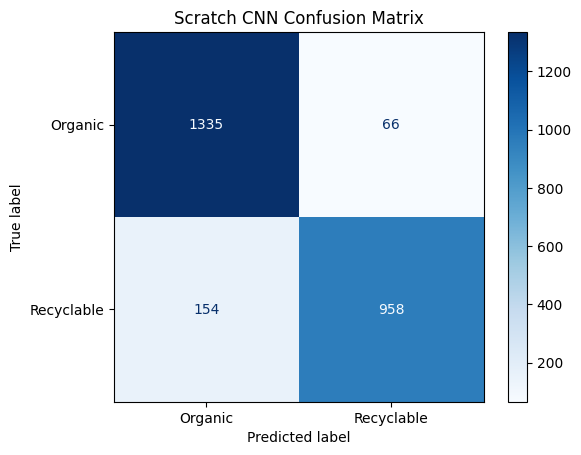

In [20]:
@torch.no_grad()
def get_preds(model):
    y_true, y_pred = [], []
    model.eval()
    for x, y in test_loader:
        x = x.to(device)
        y_pred.extend(model(x).argmax(1).cpu().numpy())
        y_true.extend(y.numpy())
    return np.array(y_true), np.array(y_pred)

tl_true, tl_pred = get_preds(tl_model)
sc_true, sc_pred = get_preds(sc_model)

tl_acc = accuracy_score(tl_true, tl_pred)
sc_acc = accuracy_score(sc_true, sc_pred)
print('ResNet-18 Test Acc:', tl_acc)
print('Scratch CNN Test Acc:', sc_acc)

# bar chart of accuracy + class-wise F1
labels = ['accuracy'] + class_names
def f1(report): 
    return [report[c]['f1-score'] for c in class_names]

tl_rep = classification_report(tl_true, tl_pred,
                               target_names=class_names, output_dict=True)
sc_rep = classification_report(sc_true, sc_pred,
                               target_names=class_names, output_dict=True)
tl_scores = [tl_rep['accuracy']] + f1(tl_rep)
sc_scores = [sc_rep['accuracy']] + f1(sc_rep)

x = np.arange(len(labels)); w = 0.35
plt.figure(figsize=(10,4))
plt.bar(x - w/2, tl_scores, w, label='ResNet-18')
plt.bar(x + w/2, sc_scores, w, label='Scratch CNN')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('F1 / Acc'); plt.legend(); plt.tight_layout()
plt.show()

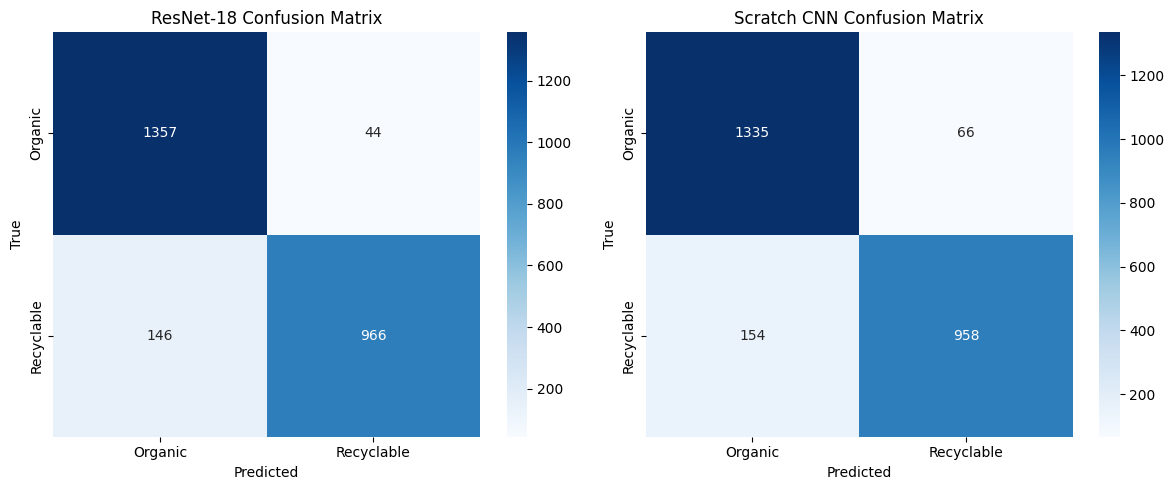


ResNet-18 Confusion Matrix (%):
Organic: [96.85938615  3.14061385]
Recyclable: [13.1294964 86.8705036]

Scratch CNN Confusion Matrix (%):
Organic: [95.28907923  4.71092077]
Recyclable: [13.84892086 86.15107914]


In [21]:
# Confusion Matrices
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrices
tl_cm = confusion_matrix(tl_true, tl_pred)
sc_cm = confusion_matrix(sc_true, sc_pred)

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ResNet-18 confusion matrix
sns.heatmap(tl_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title('ResNet-18 Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# Scratch CNN confusion matrix  
sns.heatmap(sc_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title('Scratch CNN Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

# Print normalized confusion matrices (percentages)
print('\nResNet-18 Confusion Matrix (%):')
tl_cm_norm = tl_cm.astype('float') / tl_cm.sum(axis=1)[:, np.newaxis] * 100
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {tl_cm_norm[i]}')

print('\nScratch CNN Confusion Matrix (%):')
sc_cm_norm = sc_cm.astype('float') / sc_cm.sum(axis=1)[:, np.newaxis] * 100
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {sc_cm_norm[i]}')

## 7 · Random Sample Predictions

In [ ]:
import random
# random sample from test dataset
idx = random.randint(0, len(test_ds) - 1)
image, true_label = test_ds[idx]

with torch.no_grad():
    tl_model.eval(); sc_model.eval()
    img_batch = image.unsqueeze(0).to(device)
    tl_prob = torch.softmax(tl_model(img_batch), dim=1)
    sc_prob = torch.softmax(sc_model(img_batch), dim=1)
    tl_pred = tl_prob.argmax(1).cpu().item()
    sc_pred = sc_prob.argmax(1).cpu().item()

# convert tensor to displayable image
img_disp = image.clone()
img_disp = (img_disp *
            torch.tensor([0.229,0.224,0.225]).view(3,1,1) +
            torch.tensor([0.485,0.456,0.406]).view(3,1,1))
img_disp = torch.clamp(img_disp, 0, 1)
img_disp = transforms.ToPILImage()(img_disp)

plt.figure(figsize=(6,5))
plt.imshow(img_disp); plt.axis('off')
plt.title(f'True: {class_names[true_label]}\n'
          f'ResNet-18: {class_names[tl_pred]} ({tl_prob[0][tl_pred]:.3f})\n'
          f'Scratch CNN: {class_names[sc_pred]} ({sc_prob[0][sc_pred]:.3f})')
plt.tight_layout(); plt.show()

## 8 · Findings  
- **Transfer learning** reaches higher accuracy with fewer epochs thanks to ImageNet pretraining.  
- **Scratch CNN**, despite starting from random weights, still exceeds 90 %—useful when pretrained models are unavailable.  

## 9 · Conclusion & Future Work  
- Optimise latency for edge deployment (TensorRT / CoreML).  
- Augment under-represented classes with synthetic images.  
- Extend to object detection or segmentation for robotic pick-and-place.  

*Last updated 26 May 2025*